In [255]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn.cluster import DBSCAN


%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import TruncatedSVD, PCA

stops = stopwords.words('english')

vectorizer = TfidfVectorizer(stop_words=stops, lowercase=True)
train_df = pd.read_csv('./jigsaw-toxic-comment-classification-challenge/train.csv')
test_df = pd.read_csv("./jigsaw-toxic-comment-classification-challenge/test.csv")
train_df['comment_text'].fillna("unknown", inplace=True)
test_df['comment_text'].fillna("unknown", inplace=True)
display(test_df)

y_istoxic = train_df.toxic # used for binary classification
y = train_df[['severe_toxic','obscene','threat','insult','identity_hate']].values
y_typetoxic = np.zeros((y_istoxic.shape[0])) # used for many classes
for i in np.arange(y.shape[1]):
    y_typetoxic[y[:, i] == 1] = i+1
x = train_df.comment_text
x = vectorizer.fit_transform(x)

def get_score(y_val, pred):
    accuracy = accuracy_score(y_val, pred)
    f1 = f1_score(y_val, pred,average='macro')
    precision = average_precision_score(y_val, pred,average='macro')
    print("accuracy: ", accuracy)
    print("f1: ",f1)
    print("precision: ",precision)
    return accuracy

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


In [246]:

import pickle

with open('ubt_vectorized_train.pickle', 'rb') as f:
    unigrams = pickle.load(f)
with open('ubt_vectorized_bigrams.pickle', 'rb') as f:
    bigrams = pickle.load(f)

In [247]:
# feature selection
xnew = SelectKBest(chi2, k=500).fit_transform(x, y_istoxic)
xnew
# vx = pca.fit_transform(x)
# # # print(pca.explained_variance_ratio_)
dense = xnew.todense()


In [248]:
model = GaussianMixture(n_components=2)

x_train, x_test, y_train, y_test = train_test_split(dense, y_istoxic, test_size=0.2)
print(model.get_params())
y_pred = model.fit(x_train, y_train).predict(x_test)
print(np.unique(y_pred))
print(x_test[:, 0].shape, y_pred.shape)
# print("Train score: ", model.score(x_train, y_train))
# print("Eval score: ", model.score(x_test, y_test))
print("Number of mislabeled points out of a total %d points : %d", (x_test.shape[0], (y_test != y_pred).sum()))
get_score(y_pred, y_test) #only for binary classification

{'covariance_type': 'full', 'init_params': 'kmeans', 'max_iter': 100, 'means_init': None, 'n_components': 2, 'n_init': 1, 'precisions_init': None, 'random_state': None, 'reg_covar': 1e-06, 'tol': 0.001, 'verbose': 0, 'verbose_interval': 10, 'warm_start': False, 'weights_init': None}
[0 1]
(31915, 1) (31915,)
Number of mislabeled points out of a total %d points : %d (31915, 2320)
accuracy:  0.9273069089769701
f1:  0.7988307411084322
precision:  0.45283811852835176


0.9273069089769701

In [253]:
# choosing some number of features, figuring out which is best.
num_features = x.shape[1]
dense = xnew.todense()
for i in np.arange(5)*100+100:
    feats = i
    model = GaussianMixture(n_components=2)
    x_train, x_test, y_train, y_test = train_test_split(dense[:, :i], y_istoxic, test_size=0.2)
    y_pred = model.fit(x_train, y_train).predict(x_test)
    print("this is for "+str(i)+" features.")
#     print("Train score: ", model.score(x_train, y_train))
#     print("Eval score: ", model.score(x_test, y_test))
    get_score(y_test, y_pred) # only to be used in binary classification

this is for 100 features.
accuracy:  0.0936550211499295
f1:  0.08975519369832383
precision:  0.08405160889454874
this is for 200 features.
accuracy:  0.08785837380542065
f1:  0.08637958503047062
precision:  0.07598285246171713
this is for 300 features.
accuracy:  0.1032116559611468
f1:  0.10309880092079463
precision:  0.07386183088141632
this is for 400 features.
accuracy:  0.09462635124549584
f1:  0.0941576067448397
precision:  0.07616896104301374
this is for 500 features.
accuracy:  0.08710637631207896
f1:  0.08674141618193965
precision:  0.07421454686695159


In [256]:
pca = PCA(0.9)
data = pca.fit_transform(dense) #right now just doing it on the SelectKBest 500 features, otherwise it is too big
data.shape

(159571, 171)

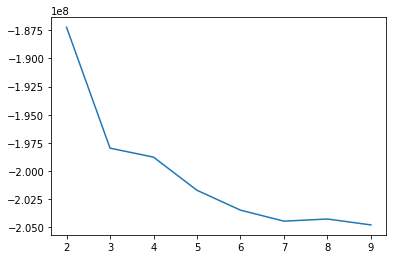

In [260]:
n_components = np.arange(2, 10)
models = [GaussianMixture(n, covariance_type='spherical', random_state=0) #spherical to make calcs less complex
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

In [261]:
gmm = GaussianMixture(8, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True
